# Este Notebook es el utilizado para replicar las transformaciones hechas para el conjunto train ahora con el dataset completo

## Salvo mención específica se han seguido las mismas transformaciones que en el Jupyter Notebook llamado train_cleaning

In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import euclidean_distances
from scipy.spatial.distance import cdist
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, OneHotEncoder , OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
import seaborn as sns
from sklearn.preprocessing import MultiLabelBinarizer

In [2]:
bnb = pd.read_csv("../data/train.csv")
bnb2 = pd.read_csv("../data/test.csv")


In [3]:
bnb3 = pd.concat([bnb,bnb2])

In [4]:
pd.set_option('display.max_columns', None)
bnb3.head()

,id,log_price,property_type,room_type,amenities,accommodates,bathrooms,bed_type,cancellation_policy,cleaning_fee,city,description,first_review,host_has_profile_pic,host_identity_verified,host_response_rate,host_since,instant_bookable,last_review,latitude,longitude,name,neighbourhood,number_of_reviews,review_scores_rating,thumbnail_url,zipcode,bedrooms,beds
0,15148661,4.499810,Apartment,Entire home/apt,"{TV,Internet,""Wireless Internet"",""Air conditio...",2,1.0,Real Bed,flexible,True,NYC,A great spacious apartment in an awesome and c...,2016-07-25,t,t,80%,2015-11-04,f,2017-09-10,40.757349,-73.921339,Sunny Spacious Apt in Astoria w/ back yard access,Astoria,9,96.0,https://a0.muscache.com/im/pictures/3e40924b-7...,11101,1.0,1.0
1,1227528,3.970292,Apartment,Private room,"{Internet,""Wireless Internet"",""Air conditionin...",2,1.0,Futon,strict,True,NYC,Newly Renovated Two Bedroom Apartment in Hamil...,2016-09-01,t,t,NaN,2014-08-26,f,2017-01-05,40.823556,-73.954573,Manhattan Sunny Private Room,Hamilton Heights,8,100.0,https://a0.muscache.com/im/pictures/2953dddd-0...,10031,1.0,1.0
2,15692740,4.787492,Apartment,Entire home/apt,"{""Wireless Internet"",""Air conditioning"",""Wheel...",4,1.0,Real Bed,moderate,True,NYC,"One bedroom, one bathroom apartment, with an o...",2016-01-05,t,t,100%,2011-01-29,f,2017-09-27,40.689306,-73.955478,Sweet Apartment on Quiet Block,Bedford-Stuyvesant,12,100.0,NaN,11205,1.0,1.0
3,19115685,4.700480,Apartment,Entire home/apt,"{Internet,""Wireless Internet"",""Air conditionin...",3,NaN,Real Bed,moderate,False,NYC,"Comfy, art- and book-filled one-bedroom apartm...",2014-01-06,t,f,NaN,2011-10-26,f,2014-01-13,40.681965,-73.965490,Husband & Wife Art-Filled Apartment,Clinton Hill,2,90.0,https://a0.muscache.com/im/pictures/81766960/b...,11238.0,1.0,1.0
4,2554110,5.192957,Apartment,Entire home/apt,"{TV,""Wireless Internet"",""Air conditioning"",Kit...",3,1.0,Real Bed,strict,True,NYC,1br/1ba. Spacious living room with plenty of s...,2016-05-20,t,f,NaN,2012-06-21,f,2016-05-20,40.742842,-73.957554,Luxurious 1 Bedroom Apt!,Long Island City,1,80.0,https://a0.muscache.com/im/pictures/0ed6ee9e-6...,11101,1.0,1.0


In [5]:
bnb3.info(memory_usage = "deep")

<class 'pandas.core.frame.DataFrame'>
Int64Index: 74111 entries, 0 to 14822
Data columns (total 29 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   id                      74111 non-null  int64  
 1   log_price               59288 non-null  float64
 2   property_type           74111 non-null  object 
 3   room_type               74111 non-null  object 
 4   amenities               74111 non-null  object 
 5   accommodates            74111 non-null  int64  
 6   bathrooms               73911 non-null  float64
 7   bed_type                74111 non-null  object 
 8   cancellation_policy     74111 non-null  object 
 9   cleaning_fee            74111 non-null  bool   
 10  city                    74111 non-null  object 
 11  description             74111 non-null  object 
 12  first_review            58247 non-null  object 
 13  host_has_profile_pic    73923 non-null  object 
 14  host_identity_verified  73923 non-null

# Convierto todos los property_type que aparecen menos de 10 veces por "Other"

In [6]:
prop_counts = bnb3['property_type'].value_counts()
prop_counts

Apartment             49003
House                 16511
Condominium            2658
Townhouse              1692
Loft                   1244
Other                   607
Guesthouse              498
Bed & Breakfast         462
Bungalow                366
Villa                   179
Dorm                    142
Guest suite             123
Camper/RV                94
Timeshare                77
Cabin                    72
In-law                   71
Hostel                   70
Boutique hotel           69
Boat                     65
Serviced apartment       21
Tent                     18
Castle                   13
Vacation home            11
Yurt                      9
Hut                       8
Treehouse                 7
Chalet                    6
Earth House               4
Tipi                      3
Cave                      2
Train                     2
Lighthouse                1
Casa particular           1
Island                    1
Parking Space             1
Name: property_type,

In [7]:
# Identificar tipos con recuento menor que 10
tipos_a_cambiar = prop_counts[prop_counts < 10].index

# Cambiar los valores en la columna property_type
bnb3['property_type'] = bnb3['property_type'].map(lambda x: 'Other' if x in tipos_a_cambiar else x)


# Relleno los valores nulos en la columna bathroom con el promedio de baños para el número de huespedes 

In [8]:
# Calcular el promedio de baños para cada número de acomodates
average_bathrooms = bnb3.groupby('accommodates')['bathrooms'].transform('mean')

# Llenar los valores nulos en la columna 'bathrooms' con los promedios calculados
bnb3['bathrooms'] = bnb3['bathrooms'].fillna(average_bathrooms)
bnb3['bathrooms'] = bnb3['bathrooms'].round(1)

# Paso la columna cleaning_fee de tipo bool a int

In [9]:
bnb3['cleaning_fee'] = bnb3['cleaning_fee'].astype(int)

# Parece que no hay gran diferencia entre tener foto de perfil o estar verificado en el log_price por lo que se van a eliminar esas dos columnas


In [10]:
columnas_a_eliminar = ['host_has_profile_pic', 'host_identity_verified']
bnb3 = bnb3.drop(columnas_a_eliminar, axis=1)

# Relleno los nulos de la columna host_since por el valor de first_review cuando sea posible, y por la fecha más reciente de host_since cuando first_review sea nulo tambien

In [11]:
bnb3['host_since'] = bnb3['host_since'].fillna(bnb3['first_review'])

In [12]:
bnb3['host_since'] = bnb3['host_since'].fillna("-")

In [13]:
bnb3['host_since'] = bnb3['host_since'].replace('-', '2017-10-04')

In [14]:
bnb3 = bnb3.drop("first_review", axis=1)

In [15]:
bnb3['host_response_rate'] = bnb3['host_response_rate'].str.rstrip('%').astype('float')

# Rellenar los valores nulos con la media
media = bnb3['host_response_rate'].mean()
bnb3['host_response_rate'].fillna(media, inplace=True)


In [16]:
bnb3['host_response_rate'] = bnb3['host_response_rate'].astype(int)

# Cambio la columna instant_bookable a binario

In [17]:
bnb3['instant_bookable'] = bnb3['instant_bookable'].replace('f', 0)
bnb3['instant_bookable'] = bnb3['instant_bookable'].replace('t', 1)

# Elimino la columna last_review y las columnas latitude y longitude ya que posteriormente voy a tratar de cuantificar la ubicación del alojamiento mediante clusterización de neighbourhood

In [18]:
bnb3 = bnb3.drop("last_review", axis=1)


In [19]:
len(bnb3[bnb3.neighbourhood.isna()])

6872

# Utilizo el modelo NearestNeighbors para asignar un barrio a aquellos valores nulos en función de las columnas ['latitude', 'longitude']

In [20]:
bnb_nulos = bnb3[bnb3['neighbourhood'].isnull()]

# Filtrar las filas sin valores nulos en 'barrio'
bnb_no_nulos = bnb3.dropna(subset=['neighbourhood'])

# Definir el número de vecinos cercanos a considerar
num_neighbors = 1

# Inicializar el modelo NearestNeighbors
neighbors_model = NearestNeighbors(n_neighbors=num_neighbors)

# Ajustar el modelo a las coordenadas sin valores nulos en 'barrio'
neighbors_model.fit(bnb_no_nulos[['latitude', 'longitude']])

# Encontrar los vecinos más cercanos para las filas con valores nulos en 'barrio'
distances, indices = neighbors_model.kneighbors(bnb_nulos[['latitude', 'longitude']])

# Asociar los valores nulos en 'barrio' con los barrios correspondientes de los vecinos más cercanos
bnb3.loc[bnb3['neighbourhood'].isnull(), 'neighbourhood'] = bnb_no_nulos.iloc[indices[:, 0]]['neighbourhood'].values


In [21]:
bnb3 = bnb3.drop("thumbnail_url", axis=1)
bnb3 = bnb3.drop("zipcode", axis=1)

In [22]:
bnb3['review_scores_rating'] = bnb3['review_scores_rating'].fillna(bnb3.review_scores_rating.mean())


# Relleno los valores nulos en la columna bathroom con el promedio de baños para el número de huespedes 

In [23]:
average_bedrooms = bnb3.groupby('accommodates')['bedrooms'].transform('mean')

# Llenar los valores nulos en la columna 'bathrooms' con los promedios calculados
bnb3['bedrooms'] = bnb3['bedrooms'].fillna(average_bedrooms)
bnb3['bedrooms'] = bnb3['bedrooms'].round(1)

In [24]:
bnb3['bedrooms'] = bnb3['bedrooms'].astype(int)

In [25]:
bnb3['review_scores_rating'] = bnb3['review_scores_rating'].astype(int)

In [26]:
bnb3 = bnb3.drop("name", axis=1)
bnb3 = bnb3.drop("amenities", axis=1)

In [27]:
average_bedrooms = bnb3.groupby('accommodates')['beds'].transform('mean')

# Llenar los valores nulos en la columna 'bathrooms' con los promedios calculados
bnb3['beds'] = bnb3['beds'].fillna(average_bedrooms)
bnb3['beds'] = bnb3['beds'].round(1)
bnb3['beds'] = bnb3['beds'].astype(int)

# Utilizo la columna host_since para categorizar la antiguedad del host en 4 categorías

In [28]:
# Convertir la columna 'host_since' a tipo datetime
bnb3['host_since'] = pd.to_datetime(bnb3['host_since'])

# 1. Extracción de Año y Mes
bnb3['host_year'] = bnb3['host_since'].dt.year
bnb3['host_month'] = bnb3['host_since'].dt.month

# 2. Calcular la Antigüedad en Años
bnb3['host_age_years'] = (pd.to_datetime('2017-10-04 00:00:00') - bnb3['host_since']).dt.days / 365.25

# 3. Creación de Categorías por Rangos de Tiempo
bins = [0, 1, 2, 5, float('inf')]  # Ajustar los puntos de corte según el rango de fechas
labels = ['nuevo', 'poco_experimentado', 'experimentado', 'muy_experimentado']
bnb3['host_experience'] = pd.cut(bnb3['host_age_years'], bins=bins, labels=labels)

In [29]:
bnb3.host_experience.value_counts()

experimentado         38556
poco_experimentado    14540
muy_experimentado     13497
nuevo                  7474
Name: host_experience, dtype: int64

In [30]:
columns = ['host_year', 'host_month']
bnb3 = bnb3.drop(columns, axis=1)

# Separo ambos Dataframes en 2

In [31]:
bnb4 = bnb3[bnb3.log_price.isna()]

In [32]:
bnb3 =bnb3[bnb3.log_price.notna()]

# Clusterizo los barrios solo con train

In [33]:
# Asumiendo que 'log_price' y 'neighbourhood' son columnas relevantes en tu DataFrame
X = bnb3[['log_price', 'neighbourhood']]

# Calcula la media del log_price para cada barrio
neighbourhood_means = X.groupby('neighbourhood')['log_price'].mean().reset_index()

# Crea un DataFrame con las medias del log_price por barrio
neighbourhood_means.columns = ['neighbourhood', 'log_price_mean']

# Normaliza la columna 'log_price_mean'
scaler = StandardScaler()
neighbourhood_means_scaled = scaler.fit_transform(neighbourhood_means[['log_price_mean']])

# Aplica el algoritmo de k-means a las medias normalizadas
kmeans = KMeans(n_clusters=10, random_state=42)
neighbourhood_means['neighbourhood_cluster'] = kmeans.fit_predict(neighbourhood_means_scaled)

# Ordena los clusters según la media del log_price
cluster_order = neighbourhood_means.groupby('neighbourhood_cluster')['log_price_mean'].mean().sort_values().index
neighbourhood_means['neighbourhood_cluster'] = neighbourhood_means['neighbourhood_cluster'].map(
    {cluster: order + 1 for order, cluster in enumerate(cluster_order)}
)

# Crea un diccionario de mapeo de barrios a clusters
neighbourhood_cluster_mapping = dict(zip(neighbourhood_means['neighbourhood'], neighbourhood_means['neighbourhood_cluster']))

# Aplica el mapeo de clusters al DataFrame original
bnb3['neighbourhood_cluster'] = bnb3['neighbourhood'].map(neighbourhood_cluster_mapping)

C:\Users\daarr\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\daarr\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


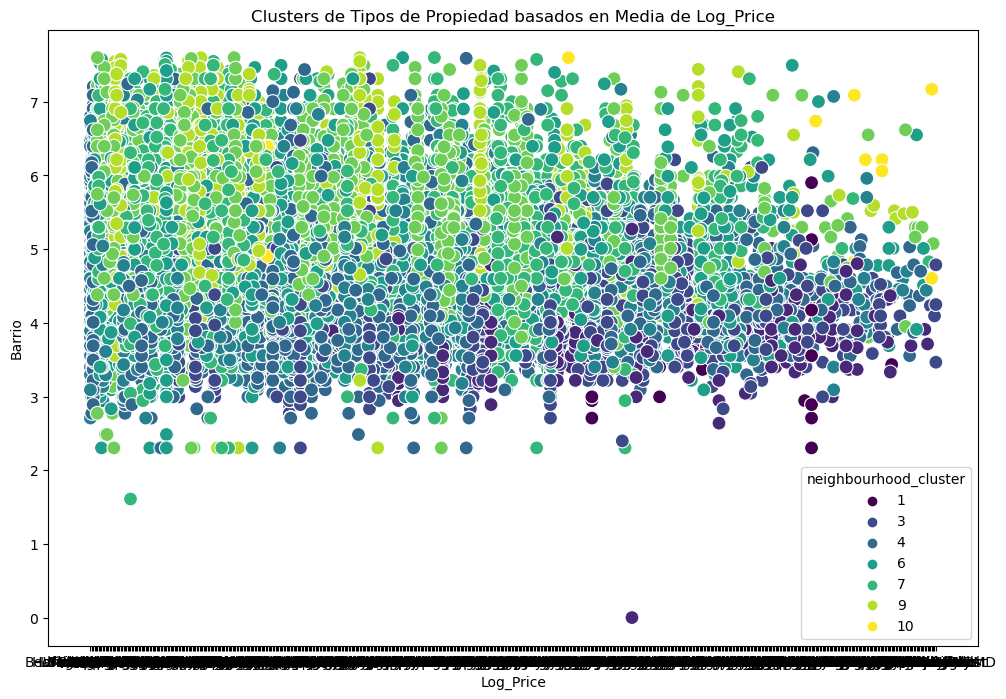

In [40]:
plt.figure(figsize=(12, 8))
scatter = sns.scatterplot(y='log_price', x='neighbourhood', hue='neighbourhood_cluster',
                           data=bnb3, palette='viridis', s=100)


# Agregar la leyenda personalizada


plt.title('Clusters de Tipos de Propiedad basados en Media de Log_Price')
plt.xlabel('Log_Price')
plt.ylabel('Barrio')
plt.show();

In [ ]:
bnb3.neighbourhood_cluster.value_counts()

# Genero una variable mean_log_price como la media del log_price de los pares property_type - accommodates solo con train

In [ ]:
# Supongamos que 'bnb' es tu DataFrame
# Calcula la media del log_price para cada combinación de property_type y accommodates
grouped_df = bnb3.groupby(['property_type','accommodates'])['log_price'].mean().reset_index()

# Renombra la columna resultante
grouped_df = grouped_df.rename(columns={'log_price': 'mean_log_price'})

# Fusiona los resultados de nuevo en el DataFrame original
bnb3 = pd.merge(bnb3, grouped_df, on=['property_type','accommodates'], how='left')

# Busco el par property_type - accommodates de cada row en test y le asigno el mean_log_price correspondiente

In [ ]:
# Crea un diccionario de mapeo basado en la combinación de 'property_type' y 'accommodates'
mapping_dict = bnb3.groupby(['property_type', 'accommodates'])['mean_log_price'].mean().to_dict()

# Mapa de valores de 'mean_log_price' al DataFrame a predecir
bnb4['mean_log_price'] = bnb4[['property_type', 'accommodates']].apply(lambda x: mapping_dict.get(tuple(x), np.nan), axis=1)

# Si hay valores nulos después de la asignación, llenarlos con la media global
mean_log_price_global = bnb3['log_price'].mean()
bnb4['mean_log_price'].fillna(mean_log_price_global, inplace=True)

# Vuelvo a juntar los Dataframes train y test

In [ ]:
bnb3 = pd.concat([bnb3,bnb4])

# Le asigno el cluster correspondiente a cada neighbourhood y el valor del cluster intermedio en caso de que el barrio no se encuentre en train

In [ ]:
barrio_cluster_mapping = bnb3.groupby('neighbourhood')['neighbourhood_cluster'].apply(lambda x: x.mode().iat[0] if not x.mode().empty else None).to_dict()
barrio_cluster_mapping


In [ ]:
# Llenar los valores nulos usando el diccionario
bnb3['neighbourhood_cluster'] = bnb3['neighbourhood'].map(barrio_cluster_mapping).fillna(bnb3['neighbourhood_cluster'])


In [ ]:
bnb3['neighbourhood_cluster'] = bnb3['neighbourhood_cluster'].fillna(5)

In [ ]:
bnb3 = bnb3.drop("latitude", axis=1)
bnb3 = bnb3.drop("longitude", axis=1)

In [ ]:
bnb3['host_experience'] = bnb3['host_experience'].fillna("nuevo")

In [ ]:
columns = ["host_age_years","host_since"]
bnb3 = bnb3.drop(columns, axis=1)

In [ ]:
bnb4 = bnb3[bnb3.log_price.isna()]

In [ ]:
bnb4 = bnb4.drop("log_price", axis=1)

In [ ]:
bnb4.info(memory_usage = "deep")

# Me quedo con las columnas de mayor interés

In [ ]:
bnb4 = bnb4[['room_type', 'cleaning_fee','bed_type',
           'cancellation_policy','city','host_experience','beds', 'host_response_rate','review_scores_rating','number_of_reviews',              
           'accommodates','bathrooms', 'bedrooms', 'property_type','mean_log_price','neighbourhood_cluster','neighbourhood']]

In [ ]:
bnb4.to_csv("../data/test_clean2.csv", index=False)

In [ ]:
bnb3 = bnb3[bnb3.log_price.notna()]

In [ ]:
bnb3 = bnb3[bnb3.log_price != 0]

In [ ]:
bnb3 = bnb3[['log_price','room_type', 'cleaning_fee','bed_type',
           'cancellation_policy','city','host_experience','beds', 'host_response_rate','review_scores_rating','number_of_reviews',              
           'accommodates','bathrooms', 'bedrooms', 'property_type','mean_log_price','neighbourhood_cluster','neighbourhood']]

In [ ]:
bnb3.to_csv("../data/train_clean4.csv", index=False)